## GLMAT: 2D kernel, song stimuli, ML+MC estimation

This notebook demonstrates the full assimilation technique using song stimuli. The song waveform is processed to a 2D spectrogram, then convolved with a 2D STRF to produce the "voltage" of the GLMAT model. The adaptation "current" is calculated by convolving the spike trains with two exponential kernels. The goal of the assimilation is to estimate the parameters of the RF and the adaptation kernels. The parameter count of the RF is minimized by using a low-rank approximation (i.e., an outer product of two vectors) and by projecting time into a basis set of raised cosine filters that are spaced exponentially.

The approach is to use elastic-net penalized maximum-likelihood estimation to get a first guess at the parameters. The regularization parameters and rank are selected using cross-validation. Then MCMC is used to sample the posterior distribution of the parameters.

In [1]:
from __future__ import print_function, division
import os
import sys
import imp
import numpy as np

import yaml

import mat_neuron._model as mat
from dstrf import strf, mle, io, performance, spikes

# plotting packages
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.aspect'] = 'auto'
mpl.rcParams['image.cmap'] = 'jet'

The MAT model is governed by a small number of parameters: the spike threshold (omega), the amplitudes of the adaptation kernels (alpha_1, alpha_2), the time constants of the adaptation kernels (tau_1, tau_2), and the absolute refactory period. In addition, a function must be chosen for spike generation. The 'softplus' function, log(1 + exp(mu)), is a good choice because it doesn't saturate as readily when mu is large. Because there can only be one spike per bin, saturation causes the estimated parameters to be less than the true parameters.

In [2]:
with open("../../scripts/default-nogamma.yml","r") as yf:
    config = yaml.load(yf, Loader=yaml.Loader)
    
# set variables based on `config`
ntaus = len(config["mat"]["taus"])
mat_fixed = np.asanyarray(config["mat"]["taus"] + [config["mat"]["refract"]],dtype='d')
upsample = int(config["strf"]["stim_dt"] / config["mat"]["model_dt"])
kcosbas = strf.cosbasis(config["strf"]["ntau"], config["strf"]["ntbas"])
ntbas = kcosbas.shape[1]

Here we load some data from a real neural recording from the CRCNS dataset. To simplify the model, we concatenate the stimuli, setting padding between the stimuli sufficient to capture any offset responses. Note that the spike responses are convolved with the adaptation kernels before merging stimuli so that we don't inadvertently carry over spike history from trials that are not truly contiguous.

In [3]:
pad_after = config["strf"]["ntau"] * config["strf"]["stim_dt"] # how much to pad after offset

# load stimuli and responses
root = "/scratch/dmeliza/modeldata/SNR4posp-norm/"
cell = "posp-rs-35"

data = io.load_rothman(cell,root, 
                     config["strf"]["spec_window"], config["strf"]["stim_dt"], 
                     f_min=config["strf"]["f_min"], 
                     f_max=config["strf"]["f_max"], f_count=config["strf"]["nfreq"], 
                     compress=config["strf"]["spec_compress"], 
                     gammatone=config["strf"]["gammatone"])
io.pad_stimuli(data, config["data"]["pad_before"], pad_after, fill_value=0.0)
io.preprocess_spikes(data, config["mat"]["model_dt"], config["mat"]["taus"])

n_test = int(config["data"]["p_test"] * len(data))

# split into assimilation and test sets and merge stimuli
assim_data = io.merge_data(data[:-n_test])
test_data = io.merge_data(data[-n_test:])

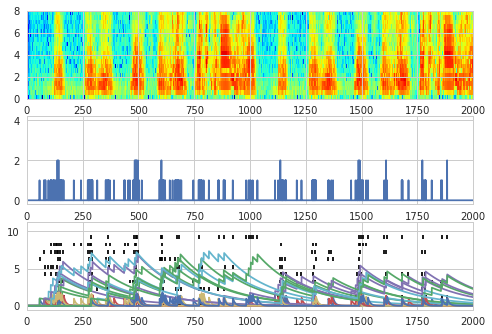

In [4]:
stim = assim_data["stim"]

plt.subplot(311).imshow(stim, extent=(0, assim_data["duration"], 
                                            config["strf"]["f_min"], config["strf"]["f_max"]))
t_spike = np.linspace(0, assim_data["duration"], assim_data["spike_v"].shape[0])
plt.subplot(312).plot(t_spike, assim_data["spike_v"].sum(1))
ax = plt.subplot(313)
for i, spk in enumerate(assim_data["spike_t"]):
    ax.vlines(spk * config["mat"]["model_dt"], i, i + 0.5)
    ax.plot(t_spike, assim_data["spike_h"][:, :, i])
for ax in plt.gcf().axes:
    ax.set_xlim(0, 2000)

## Estimate parameters

The reg_alpha and reg_lambda parameters set the L1 and L2 penalties for the initial ML estimation. Note that we supply the nonlinearity function to the constructor too, as this determines how the log-likelihood is calculated.

In [ ]:
# initial guess of parameters using penalized ML. Note that we provide the cosine basis set to the constructor of
# mle.estimator, which causes the design matrix to be in the cosine basis set
# we'll do an initial fit with some strong regularization to see if there's an RF. Leave this out of production
# NB: This cell sometimes fails in initializing the estimator; just run it again.
mlest = mle.mat(assim_data["stim"], kcosbas, assim_data["spike_v"], assim_data["spike_h"],
                assim_data["stim_dt"], assim_data["spike_dt"], nlin=config["mat"]["nlin"])
%time w0 = mlest.estimate(reg_lambda=1e2, reg_alpha=1e2)

Optimization terminated successfully.
         Current function value: 27782.105681
         Iterations: 31
         Function evaluations: 60
         Gradient evaluations: 90
         Hessian evaluations: 192
CPU times: user 25.5 s, sys: 0 ns, total: 25.5 s
Wall time: 25.5 s


The regularization parameters (L1/L2 ratio and total penalty) are chosen using cross-validation.

In [ ]:
import progressbar
from dstrf import crossvalidate

l1_ratios = config["crossval"]["l1_ratios"]
#l1_ratios = [0.9]

reg_grid = np.logspace(config["crossval"]["logspace_start"], config["crossval"]["logspace_end"], 
                       config["crossval"]["logspace_steps"])[::-1]
#reg_grid = [1e1]

bar = progressbar.ProgressBar(max_value=2 * len(l1_ratios) * len(reg_grid),
                              widgets=[
                                ' [', progressbar.Timer(), '] ',
                                progressbar.Bar(),
                                ' (', progressbar.ETA(), ') ',
                            ])

i = 0
scores = []
results = []
for krank in (1, 2):
    mlest = mle.matfact(assim_data["stim"], kcosbas, krank, assim_data["spike_v"], assim_data["spike_h"],
                        assim_data["stim_dt"], assim_data["spike_dt"], nlin=config["mat"]["nlin"])
    for reg, s, w in crossvalidate.elasticnet(mlest, 4, reg_grid, l1_ratios, avextol=1e-5, disp=False):
        i += 1
        bar.update(i)
        scores.append(s)
        results.append((reg, krank, s, w))
    
best_idx = np.argmax(scores)
best = results[best_idx]

krank = best[1]
rf_alpha, rf_lambda = best[0]
w0 = best[3]
print("best solution: rank={}, alpha={}, lambda={}, loglike={}".format(krank, rf_alpha, rf_lambda, best[2]))

 [Elapsed Time: 0:27:26] |##############                               | (ETA: 1:00:07) 

In [12]:
mlest = mle.matfact(assim_data["stim"], kcosbas, krank, assim_data["spike_v"], assim_data["spike_h"],
                        assim_data["stim_dt"], assim_data["spike_dt"], 
                        nlin=config["mat"]["nlin"])

[ 6.0374866   1.02053889 -0.31924116]


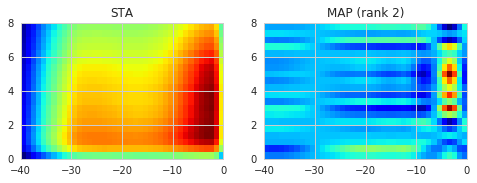

In [13]:
print(w0[:3])
rf_sta = strf.as_matrix(mlest.sta(), kcosbas)
rf_mle = strf.from_basis(mlest.strf(w0), kcosbas)
plt.subplot(221).imshow(rf_sta, extent=(-config["strf"]["ntau"], 0, config["strf"]["f_min"], config["strf"]["f_max"]))
plt.title("STA")
plt.subplot(222).imshow(rf_mle, extent=(-config["strf"]["ntau"], 0, config["strf"]["f_min"], config["strf"]["f_max"]))
plt.title("MAP (rank {})".format(krank))

loglike: -27499.930807064222
CC: 0.07858881091305205/0.6248139903793077
spike count: data = 5796, pred = 79304


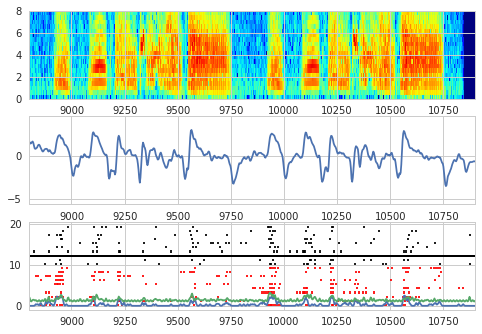

In [14]:
n_ppost = 10
mat.random_seed(1)
t_stim = np.linspace(0, assim_data["duration"], assim_data["stim"].shape[1])
plt.subplot(311).imshow(assim_data["stim"], extent=(0, assim_data["duration"], 
                                                   config["strf"]["f_min"], config["strf"]["f_max"]))
V = mlest.V(w0)
plt.subplot(312).plot(t_stim, V)
ax = plt.subplot(313)
for j, spk in enumerate(assim_data["spike_t"]):
    ax.vlines(spk * config["mat"]["model_dt"], j, j + 0.5, 'r')
pred = np.zeros_like(assim_data["spike_v"])
for i in range(n_ppost):
    pred[:, i] = mlest.predict(w0, mat_fixed, V)
    spk_t = pred[:, i].nonzero()[0]
    ax.vlines(spk_t * config["mat"]["model_dt"], i + j + 1, i + j + 1.5)
pred_psth = spikes.psth(pred, upsample, 1)
test_psth = spikes.psth(assim_data["spike_v"], upsample, 1)
ax.plot(t_stim, test_psth, t_stim, pred_psth)
for ax in plt.gcf().axes:
    ax.set_xlim(8800, 10900)

eo = performance.corrcoef(assim_data["spike_v"][:,::2], assim_data["spike_v"][:,1::2], downsample=upsample, smooth=1)
print("loglike: {}".format(-mlest.loglike(w0)))
print("CC: {}/{}".format(np.corrcoef(test_psth, pred_psth)[0, 1], eo))
print("spike count: data = {}, pred = {}".format(assim_data["spike_v"].sum(), pred.sum()))

loglike: -6844.324828352885
CC: 0.20725564414314376/0.6390099616005462
spike count: data = 1459, pred = 6623


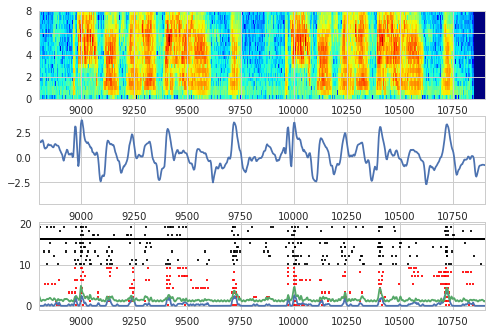

In [15]:
mltest = mle.matfact(test_data["stim"], kcosbas, krank, test_data["spike_v"], test_data["spike_h"],
                     test_data["stim_dt"], test_data["spike_dt"], nlin=config["mat"]["nlin"])

n_ppost = 10
mat.random_seed(1)
t_stim = np.linspace(0, test_data["duration"], test_data["stim"].shape[1])
plt.subplot(311).imshow(test_data["stim"], extent=(0, test_data["duration"], 
                                                   config["strf"]["f_min"], config["strf"]["f_max"]))
V = mltest.V(w0)
plt.subplot(312).plot(t_stim, V)
ax = plt.subplot(313)
for j, spk in enumerate(test_data["spike_t"]):
    ax.vlines(spk * config["mat"]["model_dt"], j, j + 0.5, 'r')
pred = np.zeros_like(test_data["spike_v"])
for i in range(n_ppost):
    pred[:, i] = mltest.predict(w0, mat_fixed, V)
    spk_t = pred[:, i].nonzero()[0]
    ax.vlines(spk_t * config["mat"]["model_dt"], i + j + 1, i + j + 1.5)
pred_psth = spikes.psth(pred, upsample, 1)
test_psth = spikes.psth(test_data["spike_v"], upsample, 1)
ax.plot(t_stim, test_psth, t_stim, pred_psth)
for ax in plt.gcf().axes:
    ax.set_xlim(8800, 10900)

eo = performance.corrcoef(test_data["spike_v"][:,::2], test_data["spike_v"][:,1::2], downsample=upsample, smooth=1)
print("loglike: {}".format(-mltest.loglike(w0)))
print("CC: {}/{}".format(np.corrcoef(test_psth, pred_psth)[0, 1], eo))
print("spike count: data = {}, pred = {}".format(test_data["spike_v"].sum(), pred.sum()))

In [16]:
# import pickle
# with open('split-test.dat', 'wb') as outfile:
#     pickle.dump(dict(w0=w0,
#                   assim_data=assim_data,
#                   test_data=test_data,
#                   rf_lambda=rf_lambda,
#                   rf_alpha=rf_alpha,
#                  krank=krank,
#                  mlest=mlest,
#                   mltest=mltest),
#                  outfile,protocol=pickle.HIGHEST_PROTOCOL)

We'll use the ML estimate to seed the MCMC sampler. We're going to reduce the size of the parameter space by factorizing the RF (i.e., a bilinear approximation). Note that we try to use the mlest object as much as possible to do the calculations rather than reimplement things; however, there can be some significant performance enhancements from an optimized implementation.

In [17]:
# estimate parameters using emcee
from neurofit import priors, costs, utils, startpos

# the MAT parameters are just bounded between reasonable limits. These may need to be expanded when using real data"][
mat_prior = priors.joint_independent(
                [ priors.uniform(config["mat"]["bounds"][0][0], config["mat"]["bounds"][0][1]),
                  priors.uniform(config["mat"]["bounds"][1][0], config["mat"]["bounds"][1][1]),
                  priors.uniform(config["mat"]["bounds"][2][0], config["mat"]["bounds"][2][1]),
                ])

# use the regularization parameters from the cross-validation
rf_alpha, rf_lambda = best[0]

# bounds checking
def matbounds(tr, t1, t2, fudge=0.01):
    aa1 = -(1 - np.exp(-tr/t2))/(1 - np.exp(-tr/t1))
    aa2 = -(np.exp(tr/t2) - 1)/(np.exp(tr/t1) - 1)
    def f(mparams):
        return (mparams[2] > aa1 * mparams[1] + fudge) and (mparams[2] > aa2 * mparams[1] + fudge)
    return f

matboundprior = matbounds(config["mat"]["refract"], *config["mat"]["taus"])

def lnpost(theta):
    """Posterior probability for dynamical parameters"""
    mparams = theta[:3]
    rfparams = theta[3:]
    if not matboundprior(mparams):
        return -np.inf
    ll = mat_prior(mparams)
    if not np.isfinite(ll):
        return -np.inf
    w = np.r_[mparams, rfparams]
    ll -= mlest.loglike(w, rf_lambda, rf_alpha)
    return -np.inf if not np.isfinite(ll) else ll


In [18]:
print("lnpost of ML estimate: {}".format(lnpost(w0)))
%timeit lnpost(w0)

lnpost of ML estimate: -inf
1.16 µs ± 8.44 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [20]:
# tag = "test"
# save_file = saveplace + cell + "_" + tag
# np.savez(saveplace + cell + "_" + tag,w0=w0,assim_data=assim_data,test_data=test_data)

This code starts the MCMC sampler. We initialize the walkers (chains) in a gaussian around the ML estimate, with standard deviation 2x the absolute value of the best guess. The model converges fairly quickly, but then we let it sample for a while.

In [21]:
import emcee
if sys.platform == 'darwin':
    config["emcee"]["nthreads"] = 1

# initialize walkers
pos = p0 = startpos.normal_independent(config["emcee"]["nwalkers"], w0, np.abs(w0) * config["emcee"]["startpos_scale"])
# initialize the sampler
sampler = emcee.EnsembleSampler(config["emcee"]["nwalkers"], w0.size, lnpost, 
                                threads=config["emcee"]["nthreads"])

In [ ]:
# start the sampler
tracker = utils.convergence_tracker(config["emcee"]["nsteps"], 100)
for pos, prob, like in tracker(sampler.sample(pos, iterations=config["emcee"]["nsteps"], storechain=True)): 
    continue

  step  μ(lnprob)  Δ(lnprob)  σ(lnprob)        time         ETA
---------------------------------------------------------------
   100  -1.341e+21        inf  2.5016e+22     0:03:51     1:14:05
   200     -51474  1.341e+21  3.688e+05     0:08:05     1:13:09
   300     -32609      18865      68817     0:12:07     1:09:01
   400     -29215       3394     8080.2     0:16:08     1:04:45
   500     -28711     503.87     1098.1     0:20:09     1:00:38
   600     -29328    -617.55      14000     0:24:10     0:56:31
   700     -28819     508.91     3929.6     0:28:31     0:53:05


lnpost of p median: -28351.104947054882
average acceptance fraction: 0.08321100000000001
[ 6.0374866   1.02053889 -0.31924116]
[ 5.91160269  0.53337115 -0.01478685]


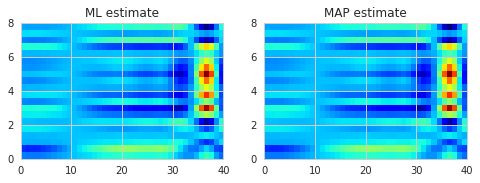

In [26]:
print("lnpost of p median: {}".format(np.median(prob)))
print("average acceptance fraction: {}".format(sampler.acceptance_fraction.mean()))
try:
    print("autocorrelation time: {}".format(sampler.acor))
except:
    pass    
w1 = np.median(pos, 0)
rfparams = w1[3:]
rf_map = strf.from_basis(mlest.strf(w0), kcosbas)
print(w0[:3])
print(w1[:3])
plt.subplot(221)
plt.imshow(rf_mle, extent=(0, config["strf"]["ntau"], config["strf"]["f_min"], config["strf"]["f_max"]))
plt.title("ML estimate")
plt.subplot(222)
plt.imshow(rf_map, extent=(0, config["strf"]["ntau"], config["strf"]["f_min"], config["strf"]["f_max"]))
plt.title("MAP estimate")

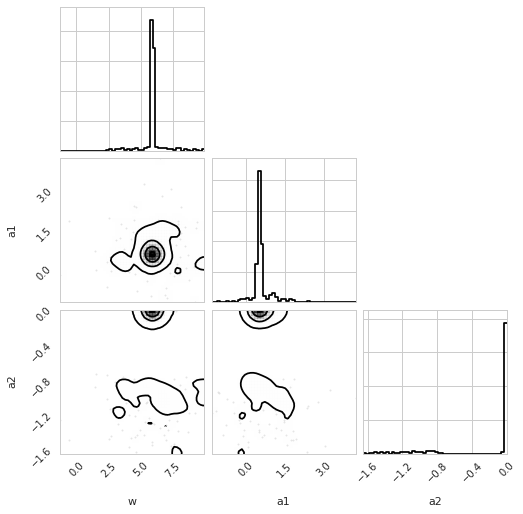

In [27]:
from corner import corner
sns.set_style("whitegrid")

mpos = pos[:,:3]
matlabs = ['w','a1','a2',]
c = corner(mpos,
       bins=50, smooth=2,smooth1d=0,
       labels=matlabs,)

loglike: -7024.061
CC: 0.635/0.639 (0.994)
spike count: data = 145.9, pred = 133.5


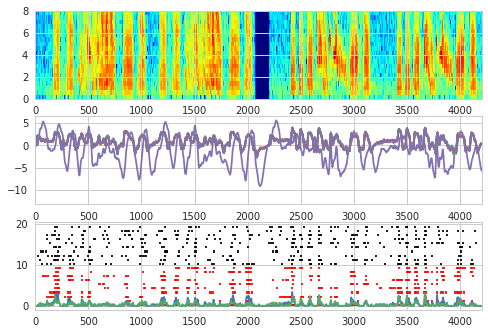

In [28]:
mpl.rcParams['image.cmap'] = 'jet'
n_ppost = 10
mat.random_seed(1)
t_stim = np.linspace(0, test_data["duration"], test_data["stim"].shape[1])
plt.subplot(311).imshow(test_data["stim"], extent=(0, test_data["duration"], 
                                                config["strf"]["f_min"], config["strf"]["f_max"]))
vax = plt.subplot(312)
ax = plt.subplot(313)
for j, spk in enumerate(test_data["spike_t"]):
    ax.vlines(spk * config["mat"]["model_dt"], j, j + 0.5, 'r')
    
samples = np.random.permutation(config["emcee"]["nwalkers"])[:n_ppost]
pred = np.zeros((test_data["spike_v"].shape[0], n_ppost), dtype=test_data["spike_v"].dtype)
i = 0
while i < n_ppost:
    idx = np.random.randint(config["emcee"]["nwalkers"])
    mparams = pos[idx]
    if not matboundprior(mparams[:3]):
        continue
    V_mc = mltest.V(mparams)
    vax.plot(t_stim, V_mc)
    pred[:, i] = mltest.predict(mparams, mat_fixed, V_mc)
    spk_t = pred[:, i].nonzero()[0]
    ax.vlines(spk_t * config["mat"]["model_dt"], i + j + 1, i + j + 1.5)
    i += 1
pred_psth = spikes.psth(pred, upsample, 1)
test_psth = spikes.psth(test_data["spike_v"], upsample, 1)
ax.plot(t_stim, test_psth, t_stim, pred_psth)
for ax in plt.gcf().axes:
    ax.set_xlim(0, 4200)

psth_corr = np.corrcoef(test_psth, pred_psth)[0, 1]
eo = performance.corrcoef(test_data["spike_v"][:,::2], test_data["spike_v"][:,1::2], upsample, 1)
print("loglike: {:.3f}".format(-mltest.loglike(w1)))
print("CC: {:.3f}/{:.3f} ({:.3f})".format(psth_corr, eo, psth_corr/eo))
print("spike count: data = {}, pred = {}".format(test_data["spike_v"].sum() / config["data"]["n_trials"], pred.sum() / n_ppost))

In [ ]:
b